In [11]:
# importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [12]:
# Loading the CSV file or the dataset
df = pd.read_csv("cscpopendata.csv")

In [13]:
# Basic inspection
print("Head:\n", df.head())
print("\nTail:\n", df.tail())
print("Data Types:\n", df.dtypes)
print("\nInfo:")
df.info()

Head:
    CDPHId                                       ProductName  CSFId  CSF  \
0       2  ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES    NaN  NaN   
1       3                        Glover's Medicated Shampoo    NaN  NaN   
2       3                        Glover's Medicated Shampoo    NaN  NaN   
3       4          PRECISION GLIMMER EYE LINER-ALL SHADES �    NaN  NaN   
4       5       AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �    NaN  NaN   

   CompanyId          CompanyName BrandName  PrimaryCategoryId  \
0          4         New Avon LLC      AVON                 44   
1        338  J. Strickland & Co.  Glover's                 18   
2        338  J. Strickland & Co.  Glover's                 18   
3          4         New Avon LLC      AVON                 44   
4          4         New Avon LLC      AVON                 44   

                     PrimaryCategory  SubCategoryId  ...   CasNumber  \
0    Makeup Products (non-permanent)             53  ...  13463-67-7   
1

In [14]:
# Drop rows where ChemicalCount is missing
df = df.dropna(subset=["ChemicalCount"])

In [15]:
# Summary and shape
print("\nShape:", df.shape)
print(df.describe(include='all'))


Shape: (114635, 22)
               CDPHId ProductName         CSFId    CSF      CompanyId  \
count   114635.000000      114635  80662.000000  80237  114635.000000   
unique            NaN       33716           NaN  34326            NaN   
top               NaN    Eyecolor           NaN  Black            NaN   
freq              NaN         766           NaN    247            NaN   
mean     20304.858987         NaN  32608.658377    NaN     450.641532   
std      12489.052554         NaN  19089.443910    NaN     409.533093   
min          2.000000         NaN      1.000000    NaN       4.000000   
25%       8717.000000         NaN  15789.000000    NaN      86.000000   
50%      20895.000000         NaN  32541.000000    NaN     297.000000   
75%      31338.500000         NaN  48717.750000    NaN     798.000000   
max      41524.000000         NaN  65009.000000    NaN    1391.000000   

        CompanyName BrandName  PrimaryCategoryId  \
count        114635    114408      114635.000000  

In [16]:
# Handling missing values
missing = df.isnull().sum()
print("Missing Values:\n", missing[missing > 0])
df.ffill(inplace=True)
df = df.dropna(subset=['CSFId', 'CSF', 'ChemicalDateRemoved'])

Missing Values:
 CSFId                   33973
CSF                     34398
BrandName                 227
CasNumber                6476
DiscontinuedDate       101715
ChemicalDateRemoved    111650
dtype: int64


In [17]:
# Dropping text/categorical columns
cols_to_drop = ['ProductName', 'ChemicalName', 'PrimaryCategory', 'SubCategory']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

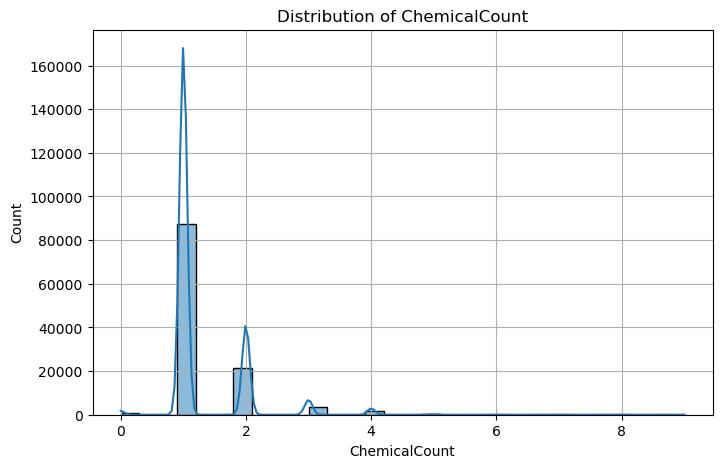

In [18]:
# EDA - Distribution and Skew
plt.figure(figsize=(8, 5))
sns.histplot(df_clean["ChemicalCount"], kde=True, bins=30)
plt.title("Distribution of ChemicalCount")
plt.grid(True)
plt.show()

In [19]:
print("Skewness:", df_clean["ChemicalCount"].skew())
print("Kurtosis:", df_clean["ChemicalCount"].kurt())

Skewness: 2.8081175756323606
Kurtosis: 13.393656817370331


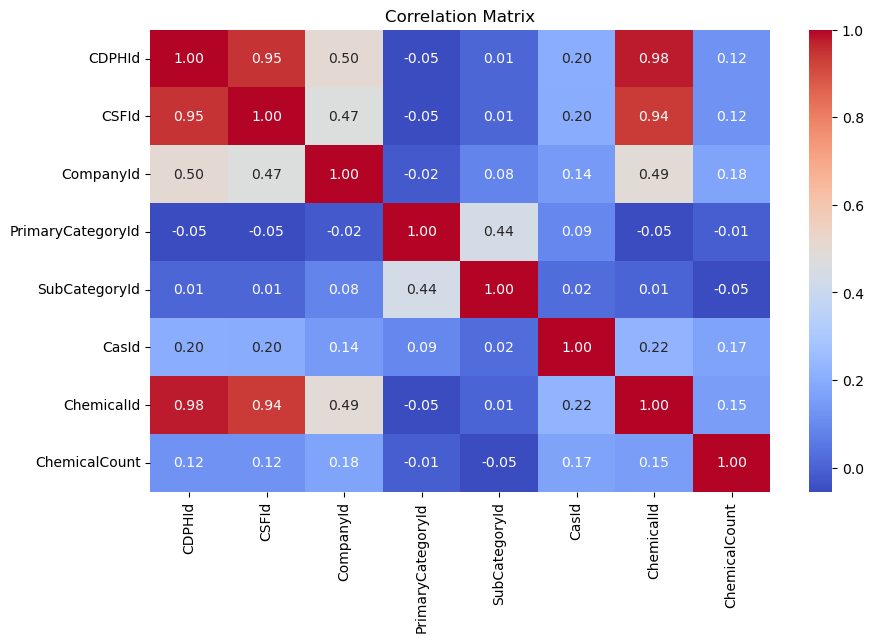

In [21]:
# Correlation Matrix
numeric_df = df_clean.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [22]:
# Outlier Detection
Q1 = df_clean['ChemicalCount'].quantile(0.25)
Q3 = df_clean['ChemicalCount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_clean[(df_clean['ChemicalCount'] < lower_bound) | (df_clean['ChemicalCount'] > upper_bound)]

In [24]:
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Total Outliers: {outliers.shape[0]}")

Lower Bound: 1.0
Upper Bound: 1.0
Total Outliers: 27366


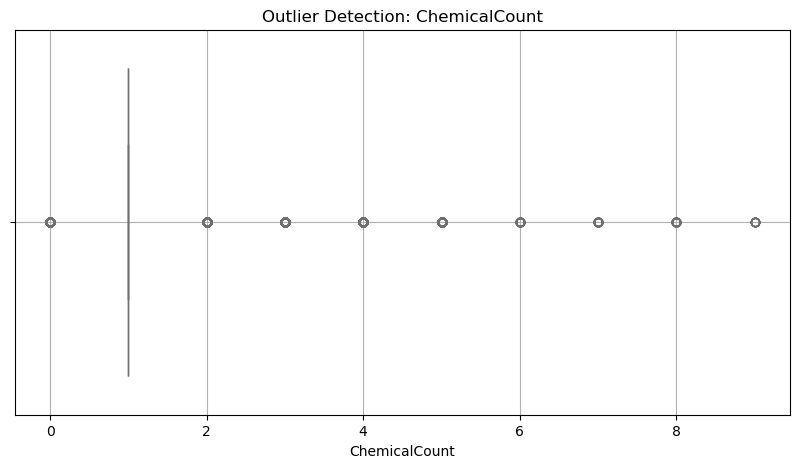

In [27]:
# plotting outlier detection
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_clean['ChemicalCount'], color='skyblue')
plt.title("Outlier Detection: ChemicalCount")
plt.grid(True)
plt.show()

In [29]:
# Preparing data for modeling
X = df_clean.select_dtypes(include=["int64", "float64"]).drop(columns=["ChemicalCount"])
y = df_clean["ChemicalCount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}


In [34]:
# Evaluation function
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape * 100:.2f}%")
    print(f"R² Score: {r2:.4f}")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE (%)": mape * 100, "R2": r2}


In [35]:
# Run models and evaluate
detailed_results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\nModel: {name}")
    metrics = evaluate_regression(y_test, y_pred)
    detailed_results[name] = metrics


Model: Linear Regression
MAE: 0.4183
MSE: 0.3767
RMSE: 0.6138
MAPE: 4206842500373733.00%
R² Score: 0.0749

Model: Decision Tree
MAE: 0.0438
MSE: 0.0592
RMSE: 0.2433
MAPE: 1336088192754218.25%
R² Score: 0.8546

Model: Random Forest
MAE: 0.0534
MSE: 0.0417
RMSE: 0.2042
MAPE: 1535519003878561.25%
R² Score: 0.8976


In [36]:
# Convert to DataFrame
result_df = pd.DataFrame(detailed_results).T.reset_index().rename(columns={"index": "Model"})

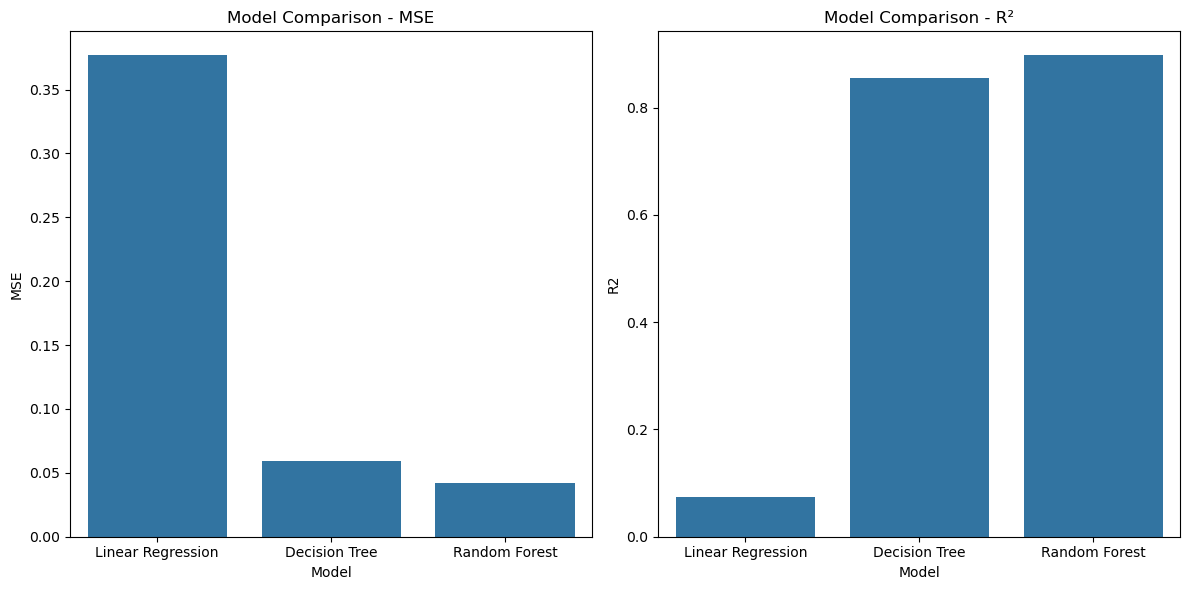


Final Evaluation Results:

               Model       MAE       MSE      RMSE      MAPE (%)        R2
0  Linear Regression  0.418329  0.376709  0.613766  4.206843e+15  0.074906
1      Decision Tree  0.043759  0.059203  0.243317  1.336088e+15  0.854613
2      Random Forest  0.053431  0.041707  0.204222  1.535519e+15  0.897580


In [39]:
# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=result_df, x="Model", y="MSE")
plt.title("Model Comparison - MSE")

plt.subplot(1, 2, 2)
sns.barplot(data=result_df, x="Model", y="R2")
plt.title("Model Comparison - R²")

plt.tight_layout()
plt.show()

print("\nFinal Evaluation Results:\n")
print(result_df)

# Conclusion
- Random Forest Regressor is the best model overall in this case
- Due to tiny or zero values in the actual target (y_test), MAPE is not reliable and should be ignored in this context.
- Linear Regression underperforms significantly, indicating the target variable ChemicalCount may have non-linear relationships that tree-based models capture better.